In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

from pymystem3 import Mystem

2024-05-30 12:11:37.248037: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 12:11:37.321415: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 12:11:37.990622: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 12:11:40.390655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mystem = Mystem()

In [3]:
def lemmatize(input_data):
  a = mystem.lemmatize(input_data)
  return "".join(a)
    
def custom_standardization(input_data):
  s = tf.strings.lower(input_data)
  s = tf.strings.regex_replace(s, 'https?://\\S+', '')
#  s = tf.strings.regex_replace(s, r'@\S+', '')
  s = tf.strings.regex_replace(s, '[%s]' % re.escape(string.punctuation), '')
  return s

In [4]:
GRADE3 = {
    'Bad':0, 
    'Neutral':1, 
    'Good':2,
}

def classify(label):
    return GRADE3[label]

In [5]:
train_data = pd.read_json("/home/vasilusa/Datasets/kinopoisk-sentiment-classification/train.jsonl", lines=True)
validation_data = pd.read_json("/home/vasilusa/Datasets/kinopoisk-sentiment-classification/validation.jsonl", lines=True)
test_data = pd.read_json("/home/vasilusa/Datasets/kinopoisk-sentiment-classification/test.jsonl", lines=True)


In [6]:
train_data

,id,text,label,label_text
0,0,"Если честно, меня не очень впечатлила новость,...",2,Good
1,1,"Сразу скажу — книгу я не читала, поэтому о том...",0,Bad
2,2,Общее впечатление таково: фильм не назовешь пл...,1,Neutral
3,3,Только что посмотрела этот «фильм». Рецензии п...,0,Bad
4,4,"Скажу сразу же, фильм — гениален! Если есть те...",2,Good
...,...,...,...,...
10495,10495,"Думаю, что фильм заслуживает просмотра.\nОт ка...",2,Good
10496,10496,"Тонны стирального порошка в виде наркотиков, н...",0,Bad
10497,10497,На этот фильм у меня даже и в планах не было и...,0,Bad
10498,10498,-Игра разумов\nНа самом деле фильм предназначе...,2,Good


In [7]:
train_raw_text_data = np.array(train_data['text'].map(lemmatize))
validation_raw_text_data = np.array(validation_data['text'].map(lemmatize))
test_raw_text_data = np.array(test_data['text'].map(lemmatize))

In [8]:
train_label_data = keras.utils.to_categorical(np.array(train_data['label']))
validation_label_data = keras.utils.to_categorical(np.array(validation_data['label']))
test_label_data = keras.utils.to_categorical(np.array(test_data['label']))

In [9]:
max_features = 20000
sequence_length = 600

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
#    standardize=custom_standardization,
    output_mode='int',
#    ngrams=2, рекуррентная сеть сама умеет считывать порядок слов
    output_sequence_length=sequence_length
)

In [10]:
base_vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    ngrams=2,
    output_sequence_length=sequence_length
)

In [11]:
train_raw_text_data

array(['если честно, я не очень впечатлить новость, о то, что гай ричи собираться снимать фильм, о шерлок холмс. подумать — да это же быть: карта, деньги, два ствол — у холмс и у ватсон. но затем по мера появление трейлер, и больший информация поменять свой отношение.\n«шерлок холмс» — последний картина, на который я планировать пойти в этот год. жутко бояться, что она я разочаровывать т. к. перед этот быть расстраивать «безумный спецназ», «так себе каникулы» и немного 2012. но холмс полностью оправдывать доверие.\nсюжет\nв лента динамичный, а главное интересный и захватывающий сюжет, что в последний время не так уж и часто. новый холмс не поход классический образ представлять в картина игорь масленников, но это не портить он образ. он больше подобный на тони старка из «железный человек» или грегори хаус из сериал «доктор хаус». как и они, он весьма харизматичный, слегка безумный, но гениальный в свой любимый дело.\nна первый взгляд сюжет портить сверхъестественный восстание из могила 

In [12]:
vectorize_layer.adapt(train_raw_text_data)

2024-05-30 12:22:52.619835: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48421472 exceeds 10% of free system memory.
2024-05-30 12:22:52.619930: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72632208 exceeds 10% of free system memory.
2024-05-30 12:22:53.171325: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24210736 exceeds 10% of free system memory.
2024-05-30 12:22:53.436019: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24210736 exceeds 10% of free system memory.


In [13]:
base_vectorize_layer.adapt(train_raw_text_data)

2024-05-30 12:22:56.505348: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48421472 exceeds 10% of free system memory.


In [14]:
base_vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'и',
 'в',
 'не',
 'что',
 'фильм',
 'на',
 'я',
 '—',
 'быть',
 'он',
 'это',
 'но',
 'с',
 'этот',
 'как',
 'а',
 'то',
 'который',
 'весь',
 'все',
 'свой',
 'так',
 'такой',
 'они',
 'к',
 'из',
 'по',
 'же',
 'о',
 'человек',
 'за',
 'бы',
 'один',
 'очень',
 'она',
 'от',
 'для',
 'у',
 'мочь',
 'мы',
 'просто',
 'только',
 'тот',
 'самый',
 'хороший',
 'его',
 'даже',
 'еще',
 'герой',
 'этот фильм',
 'то что',
 'если',
 'актер',
 'себя',
 'можно',
 'смотреть',
 'жизнь',
 'время',
 'уже',
 'или',
 'сказать',
 'сюжет',
 'первый',
 'много',
 'вот',
 'до',
 'да',
 'нет',
 'когда',
 'кино',
 'главный',
 'картина',
 'становиться',
 'сам',
 'вы',
 'мой',
 'роль',
 'ни',
 'раз',
 'другой',
 'кто',
 'и не',
 'игра',
 'понимать',
 'снимать',
 'каждый',
 'посмотреть',
 'говорить',
 'просмотр',
 'история',
 'после',
 'ну',
 'режиссер',
 'год',
 'зритель',
 'чтобы',
 'в фильм',
 'я не',
 'хотя',
 'знать',
 'хорошо',
 'в этот',
 'вообще',
 'персонаж',
 'во',
 'конечно',
 'нич

In [15]:
train_text_data = vectorize_layer(train_raw_text_data)
validation_text_data = vectorize_layer(validation_raw_text_data)
test_text_data = vectorize_layer(test_raw_text_data)

In [16]:
train_text_data_base = base_vectorize_layer(train_raw_text_data)
validation_text_data_base = base_vectorize_layer(validation_raw_text_data)
test_text_data_base = base_vectorize_layer(test_raw_text_data)

In [17]:
train_text_data

<tf.Tensor: shape=(10500, 600), dtype=int64, numpy=
array([[  51,  347,    8, ...,    0,    0,    0],
       [ 237,   60,    9, ...,    0,    0,    0],
       [ 163,  200, 1685, ...,    0,    0,    0],
       ...,
       [   7,   15,    6, ...,    0,    0,    0],
       [  81, 1100,    7, ...,    0,    0,    0],
       [ 641, 1910,    3, ...,    0,    0,    0]])>

In [18]:
embedding_dim=64

model_base = tf.keras.Sequential([
  keras.Input(shape=(None,), dtype='int64'),
  layers.Embedding(
    max_features, 
    embedding_dim,
    embeddings_initializer="uniform",
  ),  
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
#  layers.Dense(64, activation='relu'),
  layers.Dense(3)
])



In [19]:
model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,195 (4.88 MB)

 Trainable params: 1,280,195 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model_base.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', 'F1Score'])

In [21]:
base_train_ds=tf.data.Dataset.from_tensor_slices((train_text_data_base, train_label_data)).shuffle(10000).batch(64)
base_validation_ds=tf.data.Dataset.from_tensor_slices((validation_text_data_base, validation_label_data)).shuffle(10000).batch(64)

In [22]:
base_checkpoint_filepath = "models/checkpoint_kinopoisk_model_base.keras"
epochs = 10
history = model_base.fit(
    base_train_ds,
    validation_data=base_validation_ds,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=base_checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
        )        
    ]
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - F1Score: 0.3354 - accuracy: 0.3642 - loss: 1.0947 - val_F1Score: 0.1667 - val_accuracy: 0.3333 - val_loss: 1.1078
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - F1Score: 0.3685 - accuracy: 0.3854 - loss: 1.0907 - val_F1Score: 0.3583 - val_accuracy: 0.3947 - val_loss: 1.0885
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - F1Score: 0.3774 - accuracy: 0.3943 - loss: 1.0892 - val_F1Score: 0.3311 - val_accuracy: 0.3940 - val_loss: 1.0847
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - F1Score: 0.3939 - accuracy: 0.4018 - loss: 1.0872 - val_F1Score: 0.3920 - val_accuracy: 0.4273 - val_loss: 1.0799
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - F1Score: 0.4039 - accuracy: 0.4212 - loss: 1.0796 - val_F1Score: 0.3274 - val_accuracy: 0.4093 - val_loss: 1.0762
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - F1Score: 0.4344 - accuracy: 0.4412 - loss: 1.0707 - val_F1Score: 0.4000 - val_accuracy: 0.4253

In [23]:
model_base_best=tf.keras.models.load_model(base_checkpoint_filepath)

In [24]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model_base_best
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

export_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │     1,280,195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,195 (4.88 MB)

 Trainable params: 1,280,195 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

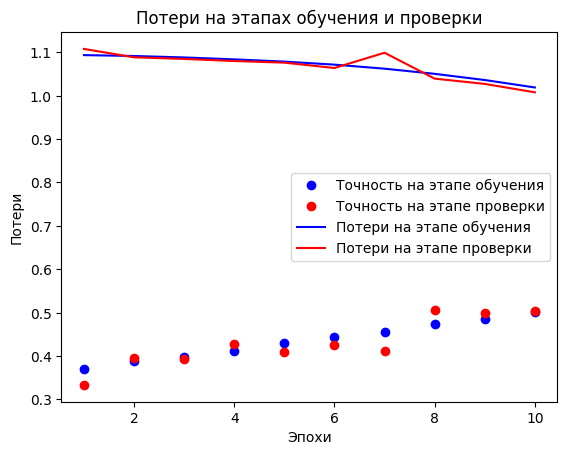

In [25]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
accuracy_values = history_dict["accuracy"]
val_accuracy_values = history_dict["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, accuracy_values, "bo", label="Точность на этапе обучения")
plt.plot(epochs, val_accuracy_values, "ro", label="Точность на этапе проверки")
plt.plot(epochs, loss_values, "b", label="Потери на этапе обучения")
plt.plot(epochs, val_loss_values, "r", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()
plt.show()

In [26]:
ltsm_embedding_dim=32

model_lstm = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    tf.keras.layers.Embedding(
        input_dim=(max_features),
        output_dim=ltsm_embedding_dim,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_lstm.summary()

model_lstm.compile(loss=losses.CategoricalCrossentropy(from_logits=False),
              optimizer='rmsprop',
              metrics=['accuracy', 'F1Score'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 32)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 698,115 (2.66 MB)

 Trainable params: 698,115 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
train_ds=tf.data.Dataset.from_tensor_slices((train_text_data, train_label_data)).shuffle(10000).batch(64)
test_ds=tf.data.Dataset.from_tensor_slices((test_text_data, test_label_data)).shuffle(10000).batch(64)
validation_ds=tf.data.Dataset.from_tensor_slices((validation_text_data, validation_label_data)).shuffle(10000).batch(64)

In [28]:
checkpoint_filepath = "models/checkpoint_kinopoisk_model_lstm.keras"

epochs = 10
history = model_lstm.fit(
    x = train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
        )        
    ]
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 100s 569ms/step - F1Score: 0.3239 - accuracy: 0.3438 - loss: 1.0948 - val_F1Score: 0.4270 - val_accuracy: 0.4953 - val_loss: 0.9828
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 82s 497ms/step - F1Score: 0.5222 - accuracy: 0.5814 - loss: 0.8773 - val_F1Score: 0.5672 - val_accuracy: 0.5860 - val_loss: 0.8555
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 83s 505ms/step - F1Score: 0.6239 - accuracy: 0.6483 - loss: 0.7504 - val_F1Score: 0.6258 - val_accuracy: 0.6373 - val_loss: 0.8093
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 82s 494ms/step - F1Score: 0.6868 - accuracy: 0.6977 - loss: 0.6774 - val_F1Score: 0.5763 - val_accuracy: 0.5780 - val_loss: 0.9258
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 78s 472ms/step - F1Score: 0.7308 - accuracy: 0.7418 - loss: 0.5937 - val_F1Score: 0.5558 - val_accuracy: 0.5687 - val_loss: 0.9295
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 79s 479ms/step - F1Score: 0.7837 - accuracy: 0.7889 - loss: 0.5144 - val_F1Score: 0.4483 - val_accuracy:

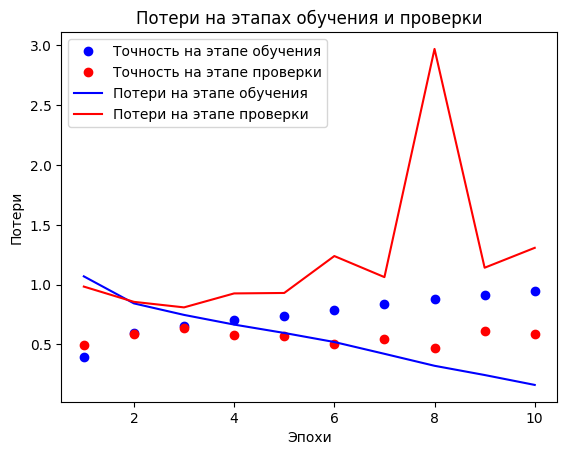

In [29]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
accuracy_values = history_dict["accuracy"]
val_accuracy_values = history_dict["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, accuracy_values, "bo", label="Точность на этапе обучения")
plt.plot(epochs, val_accuracy_values, "ro", label="Точность на этапе проверки")
plt.plot(epochs, loss_values, "b", label="Потери на этапе обучения")
plt.plot(epochs, val_loss_values, "r", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()
plt.show()

In [30]:
model_lstm_best = tf.keras.models.load_model(checkpoint_filepath)

In [31]:
model_lstm_best.evaluate(validation_ds)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - F1Score: 0.6145 - accuracy: 0.6281 - loss: 0.8244


[0.809296727180481,
 0.637333333492279,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7493061, 0.4284103, 0.6996123], dtype=float32)>]

In [32]:
export_model_lstm = tf.keras.Sequential([
  vectorize_layer,
  model_lstm_best
])

export_model_lstm.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ ?                      │       698,115 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 698,115 (2.66 MB)

 Trainable params: 698,115 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model_lstm.evaluate(
    x = validation_text_data,
    y = validation_label_data,
)

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - F1Score: 0.5915 - accuracy: 0.5930 - loss: 1.2947


[1.3061524629592896,
 0.5899999737739563,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.70881224, 0.4794007 , 0.58333325], dtype=float32)>]

In [36]:
test_text_data

<tf.Tensor: shape=(1500, 600), dtype=int64, numpy=
array([[ 194,    7, 1466, ...,    0,    0,    0],
       [ 948,   56,   15, ...,    0,    0,    0],
       [   4,  220, 3727, ...,    0,    0,    0],
       ...,
       [1317, 3769,   37, ...,    0,    0,    0],
       [2821,  104,    4, ...,    0,    0,    0],
       [ 633,  655,  734, ...,    0,    0,    0]])>

In [36]:
s0 = lemmatize('''
Являюсь студентом первого курса факультета Э
За эти три месяца, что я здесь проучилась - почувствовала лишь разочарование. Ожидания от «лучшего технического» были явно лучше. Почему же так произошло? Разберём более детально 
''')
s1 = lemmatize('''
Коротко: крепкое техническое образование с душком нафталина и просто ошеломительно-отвратительный менеджмент.
Факультет МТ, кафедра МТ-11 "Наноинженерия". Поступала я в далеком 2015 году, отчислилась по собственному желанию в середине 3 курса (с одной тройкой - по дет.машу и единственным хвостом по физкультуре), потому что решила отдать предпочтение работе. В 2022 году пришлось восстанавливаться для перевода в другой вуз, дабы добить корочку, т.к. понадобилась для повышения. И я бы ни слова не написала про альма-матер, если бы не процесс восстановления. Ребята, если вы думаете, что вы знаете, что такое поганый менеджмент, подумайте еще раз.
Немного (полезного) о самом ВУЗЕ:
Если идете в МГТУ на техническую специальность, то готовьтесь посвящать всего себя учебе. Никакой +- адекватной работы совмещать не получится, насыщенная личная жизнь тоже не светит. За посещениями следить будут жестоко и беспощадно до абсурда - можно неиронично иметь единственным хвостом физкультуру. Даже если вы честно болели, даже если принесли справку. Отрабатывать придется упорно и мучительно. По остальным специальностям - считают посещения и могут не допустить до сдачи экзамена, если много прогуляли.
Качество преподавания разнится и зависит от преподавателя. Некоторые - просто бриллианты, некоторые, мягко говоря, не очень, некоторые не справляются в силу преклонного возраста.

Но это все меркнет на фоне МЕНЕДЖМЕНТА. Если Вам не посчастливится (а рано или поздно Вы с этим столкнетесь) вписаться в какой-либо вопрос с документами, пристегните ремни.

1) Очереди в деканат и к инспекторам есть всегда, за любой подписью вам придется стоять очень долго. Про очереди на оформление социальной стипендии в приличном обществе вообще не стоит говорить вслух.
2) Если у вас не очень стандартный вопрос, готовьтесь к тому, что никто ничего не знает. Так получилось, что у меня поменялась фамилия за то время, что я была отчислена. При написании заявления на восстановление я уточнила у ОТВЕТСТВЕННОГО ПО ВОССТАНОВЛЕНИЯМ И ПЕРЕВОДАМ на кафедре, как мне заполнять форму (т.к. в базе вуза я под одной фамилией и с одними паспортными данными, а паспорт уже новый). На что он мне сказал: "Я не знаю". И мы импровизировали, т.к. ответа не знал никто.
3) С обходными листами и вообще любыми бумажками, где нужно > 1 подписи, вам придется бегать под всему вузу самостоятельно. Закладывайте сразу несколько дней (а лучше неделю), т.к. многие сотрудники не подпишут бумаги день в день, вы оставите документ на подпись и вернетесь за ним на следующий день, чтобы нести в следующий кабинет.
4) Всем плевать на ваше время. И вообще на время. Расписание работников деката не значит, что сотрудник будет на рабочем месте. Это значит, что может быть, в промежутке +- полчаса он там появится. (К инспекторам это не относится, они работают четко как часы).
4.5) Отдельно хочу отметить вышеупомянутого Ответственно по переводам, которого пришлось ловить более 2 недель, т.к. (при звонке заранее) он НЕ ЗНАЛ, когда точно будет на месте. Что не очень удобно, если вы не студент, потому что а) нужно заказывать пропуск в универ заранее б) отпрашиваться на работе
5) Хамство. Касается не всех, но если коснется, будет горячо. При оформлении восстановления одна из работниц ВУЗА (прим. НЕ в деканате, а при сборе подписей на заявления) ко мне прицепилась секретарь (видимо) сотрудника, который должен был подписать документ и начала на меня ОРАТЬ, что "я себя не уважаю, раз перевожусь из ТАКОГО вуза, с ТАКОЙ специальности в сомнительный вуз, и как вообще таким людям дают работу". При том, что я к ней даже не обращалась, с ней разговаривать не начинала, и никакого отношения к моим документам она не имеет.
6) Невероятно долгий документооборот. Студенту потребуется как минимум неделя, чтобы получить справку об обучении. В моем специфическом случае процесс восстановления -смены фамилии в базе - перевода занял почти 2(!) месяца.

Вместо послесловия. Если Вы хотите заниматься наукой, готовы 6 дней в неделю проводить в любимой шарге и вы 100% не планируете работать во время учебы, этот вуз для Вас. Пара таких моих бывших одногруппников сейчас учатся в аспирантуре и довольны. Если Вы не подходите хотя бы по одному из пунктов, подумайте еще раз. Может быть, стоит пойти в вуз полегче и не тратить силы, здоровье и нервы. Ну, и если Вы идете только потому что "это престижный вуз, а инженер - отличная специальность", а сами не знаете, чего хотите - обходите стороной.
''')

s2=lemmatize('''
Выпускник ИУ-5 бакалавра 2022 года. О Бауманке бесконечное множество разношерстных мнений и отзывов. Как минимум, так на сайте "Табитуриента". Я не буду и не могу говорить за все специальности, скажу про ИУ, конкретно, про ИУ-5. Кафедра сильная, слабее, конечно, чем ИУ-7, так как там все-таки больше программного программирования и гораздо глубже изучается разработка, но зато преподаватели на ИУ-5 более спокойные и не пытаются довезти студентов до сумасшествия. Учиться сложно, реально сложно, но если прям учиться, а не страдать ерундой. Как уже писал один молодой человек в отзывах: "Отчислить всех нельзя, приходится доучивать", поэтому есть студенты, которые вымучивают тройки на сессиях и бегают в начале каждого семестра с 3-5 долгами с предыдущего. Могу сказать сразу, "Жестко программировать" вас не научат на кафедре. Она все же дает более обширные знания по специальности. Конечно, вы потрогаете и Assembler (правда зачем?), и C++, и C#, и Python, особенно много времени уделяется машинному обучению на Питоне, коснетесь веб-разработки, но прям супер-программистом на кафедре не станете. Но это нормально, ведь для этого существует великолепная вещь - ";Технопарк", совместный проект Бауманки и Mail.Ru. Вот в технопарке вас научат всему, оттуда точно выйдете топ-разработчиками. Учиться там могут только студенты МГТУ, поэтому идти в Бауманку стоит хотя бы ради этого, оно того стоит, уж поверьте. В этом году на кафедре поменялся заведующий, отсюда сразу изменения в программе магистратуры и, в дальнейшем, бакалавриата. Изменения очень серьезные, кафедра уходит все больше в нейронки, машинное обучение, что не может не радовать, как раз набирают под это дело новый преподавательский состав. Конечно, в ВУЗе много преподавателей в возрасте, ну и конечно есть дисциплины, которые, на мой субъективный взгляд, уже не нужны, так как чисто технически устарели, но такое везде, да и их все равно потихоньку заменяют. Сам в столовой стал питаться только на последнем курсе, так как времени реально мало (обеденных перерывов в Бауманке нету), но еда вполне себе неплохая, на 180-220 рублей можно вполне себе наесться. В кафешках, конечно, дорого, тот же сэндвич обойдется уже в 180 рублей. Гуманитарные предметы, наверное, не считая правоведения, бессмысленные, знаний там, конечно, особо не дают, но технические все более-менее на уровне. Многие пишут, что "тупая зубрежка диффуров и интегралов никому не нужна", могу на этот счет высказаться так - МГТУ - это университет, и тут есть базовые предметы, которые просто должны быть по определению, иначе ВУЗ не назывался бы университетом, да и "зубрить" такое не обязательно, важно понимать, а это разница. Деканат и так, по факту, пошел навстречу студентам и убрал сопромат и химию, что, наверное, хорошо, так как специальность все-таки IT. Из минусов отдельным издевательством является физкультура, до которой надо еще успеть добраться, а если она еще и в Измайлово, или у вас бассейн, то это вообще провал. Но ее, вроде как, собираются убрать из обязательных дисциплин, так что жить можно. В целом, отучившись в МГТУ, вы получите очень неплохую корочку, если еще и Технопарк закончите, то вообще идеально. Советую идти на ИУ-7, ИУ-5, ИУ-8, ИУ-9.
''')

export_model_lstm.predict(tf.data.Dataset.from_tensor_slices([[[s0],[s1],[s2]]]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


array([[0.8022916 , 0.17948112, 0.01822735],
       [0.8728836 , 0.11685014, 0.01026627],
       [0.3760285 , 0.5409302 , 0.08304133]], dtype=float32)

In [35]:
np.sum(validation_label_data, 0)

array([500., 500., 500.])

In [37]:
keras.models.save_model(export_model_lstm, 'models/export_kinopoisk_model_lstm.keras', overwrite=True)

In [38]:
export_model_lstm_2=keras.models.load_model('models/export_kinopoisk_model_lstm.keras')

/home/vasilusa/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
export_model_lstm_2.predict(tf.data.Dataset.from_tensor_slices([[[s0],[s1],[s2]]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


array([[0.8022916 , 0.17948112, 0.01822735],
       [0.8728836 , 0.11685014, 0.01026627],
       [0.3760285 , 0.5409302 , 0.08304133]], dtype=float32)

In [42]:
export_model_lstm.evaluate(x=test_raw_text_data, y=test_label_data)

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - F1Score: 0.6207 - accuracy: 0.6369 - loss: 0.0000e+00


[0.0,
 0.0,
 0.6506666541099548,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7573528 , 0.45051187, 0.70861566], dtype=float32)>,
 0.6506666541099548,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7573528 , 0.45051187, 0.70861566], dtype=float32)>]

Проверим полученную нейросеть на данных с tabiturient.ru

In [44]:
all_tabiturient_data = pd.read_json("/home/vasilusa/Datasets/all-reviews.jsonl", lines=True)
raw_text_tabiturient_data = np.array(all_tabiturient_data['content'].map(lemmatize))
label_tabiturient_data = keras.utils.to_categorical(np.array(all_tabiturient_data['label']))

In [45]:
export_model_lstm.evaluate(x=raw_text_tabiturient_data, y=label_tabiturient_data)

114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - F1Score: 0.3838 - accuracy: 0.4783 - loss: 0.0000e+00


[0.0,
 0.0,
 0.5120945572853088,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7099588 , 0.25820807, 0.2455621 ], dtype=float32)>,
 0.5120945572853088,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7099588 , 0.25820807, 0.2455621 ], dtype=float32)>]